In [1]:
from PIL import Image
import skimage
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

import subprocess
import pylab
import re

from utilities import *

## Setup

In [2]:
# Setting root file path and finding all files to process
root_fp = '/mnt/c/Users/Alex/Documents/pax7_files/'
six_parent_folders = ! ls $root_fp
all_fps = []

for parent_folder in six_parent_folders:
    subfiles = ! ls $root_fp$parent_folder
    for subfile in subfiles:
        all_fps.append( os.path.join(root_fp,parent_folder,subfile,'') )
        
print('Total datasets: ',len(all_fps))

def load_fps( index ):
    curr_fp = all_fps[ index ]
    files = ! ls $curr_fp

    dapi_fp = '' # DAPI
    pax7_fp = '' # GREEN
    lami_fp = '' # RED, (LAMININ)
    merge_fp = '' # GRAY, CONTAINS RED ROI CIRCLES

    for fn in files:
        if 'ch00' in fn:
            dapi_fp = os.path.join(curr_fp,fn)
        if 'ch01' in fn:
            pax7_fp = os.path.join(curr_fp,fn)
        if 'ch02' in fn:
            lami_fp = os.path.join(curr_fp,fn)
        if  re.search('merge', fn, re.IGNORECASE):
            merge_fp = os.path.join(curr_fp,fn)
            
#     print(pax7_fp)
#     print(dapi_fp)
#     print(merge_fp)
    return pax7_fp, dapi_fp, merge_fp

Total datasets:  210


In [3]:
pax7_fp, dapi_fp, merge_fp = load_fps( 0 )

## Loading / Saving Images

In [72]:
def compute_true_ROIs( merge_fp, plot_results=False ):
    background = img_light_or_dark( load_img( merge_fp, convert_gray=False) )

    if background == 'light':
        img_ROI = load_img( merge_fp, convert_gray=False)
    if background == 'dark':
        img_ROI = load_img( merge_fp, convert_gray=False, channel=0 )

    ROI_locations = get_ROI( img_ROI, background=background )
    print(ROI_locations)


    x_coors = []
    y_coors = []
    for coor in ROI_locations:
        y, x = coor
        x_coors.append( int(x) )
        y_coors.append( int(y) )
    
    if plot_results:
        img_green = load_img( pax7_fp, convert_gray=True)
        plt.imshow(img_green, cmap='gray')
        plt.scatter(x=x_coors, y=y_coors, c='r', s=10)
        plt.show()
    return ROI_locations



In [73]:
def test_accuracy( index, brightness_threshold_g=0.2, brightness_threshold_b=0.02 ):
    print('\nIndex '+str(index))
    print('_________________________________________')
    
    pax7_fp, dapi_fp, merge_fp = load_fps( index )
    
    print('Processing GREEN image:')
    img_green = load_img( pax7_fp, convert_gray=True)
    #plt.imshow(img_green)
    mean, std, var, minI, maxI = get_stats_gray( img_green, exclude_under=0.15 )
    #plot_hist( img_green, bins=100, exclude_under=.12, exclude_over=1 )

    bright_coordinates_green = get_brightest_coors(img_green, \
                                                   brightness_threshold=brightness_threshold_g, \
                                                   minimum_distance=5, \
                                                   radius=5, \
                                                   convert_gray=True)


    print('Processing BLUE image:')
    img_dapi = load_img( dapi_fp, convert_gray=True)
    #plt.imshow(img_dapi)
    mean, std, var, minI, maxI = get_stats_gray( img_dapi, exclude_under=0.015 )
    #plot_hist( img_green, bins=100, exclude_under=.012, exclude_over=1 )

    bright_coordinates_dapi = get_brightest_coors(img_dapi, \
                                                  brightness_threshold=brightness_threshold_b, \
                                                  minimum_distance=10, \
                                                  convert_gray=True)

    print('Finding blue/green crossover coordinates')
    crossover_coordinates = []
    for green_coor in bright_coordinates_green:
        for dapi_coor in bright_coordinates_dapi:
            dist = get_dist(green_coor,dapi_coor)
            # If two bright points are close enough
            if dist < 10:
                avg_y = (green_coor[0] + dapi_coor[0])/2
                avg_x = (green_coor[1] + dapi_coor[1])/2
                points_too_close_together = False
                # Make sure this point is not very close to other chosen points
                for crossover_coor in crossover_coordinates:
                    cross_dist = get_dist(crossover_coor,[avg_y,avg_x])
                    if cross_dist < 25:
                        points_too_close_together = True
                if not points_too_close_together:
                    crossover_coordinates.append( [avg_y,avg_x] )



    ROI_locations = compute_true_ROIs( merge_fp )
    total_correct_ROIs = 0
    correct_ROIs = []
    for i_true in range( len(ROI_locations) ):
        for i_guess in range( len(crossover_coordinates) ):
            ROI_true = ROI_locations[i_true]
            ROI_guess = crossover_coordinates[i_guess]
            dist = get_dist(ROI_true, ROI_guess)
            if dist<100:
                total_correct_ROIs += 1
                correct_ROIs.append(ROI_true)
                

    plt.imshow(img_green, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    x_coors = []
    y_coors = []
    for coor in crossover_coordinates:
        y, x = coor
        x_coors.append( int(x) )
        y_coors.append( int(y) )
    plt.scatter(x=x_coors, y=y_coors, c='r', s=10)
    
    x_coors = []
    y_coors = []
    x_coors_correct = []
    y_coors_correct = []
    for roi_coor in ROI_locations:
        y, x = roi_coor
        correct = False
        for roi_coor_correct in correct_ROIs:
            if roi_coor==roi_coor_correct:
                x_coors_correct.append( int(x) )
                y_coors_correct.append( int(y) )
                correct = True
        if not correct:
            x_coors.append( int(x) )
            y_coors.append( int(y) )
    plt.scatter(x=x_coors, y=y_coors, c='y', s=8 )
    plt.scatter(x=x_coors_correct, y=y_coors_correct, c='b', s=8 )
    plt.show()
    
    
    print( str(total_correct_ROIs)+' correct out of '+str(len(ROI_locations)) )
    false_positives = len(crossover_coordinates) - total_correct_ROIs
    print( str(false_positives)+' false positives ' )
    try:
        return total_correct_ROIs, false_positives
    except:
        return -1, -1

In [ ]:
parameter_settings = {
    1: [0.14, 0.014],
    2: [0.14, 0.016],
    3: [0.16, 0.016],
    4: [0.16, 0.018],
    5: [0.18, 0.018],
    6: [0.18, 0.02],
    7: [0.2, 0.02],
    8: [0.2, 0.022]
}

In [61]:
parameter_settings = {
    1: [0.14, 0.014],
    2: [0.15, 0.014],
    3: [0.14, 0.015],
    4: [0.15, 0.015],
    5: [0.16, 0.015],
    6: [0.15, 0.016],
    7: [0.16, 0.016],
    8: [0.17, 0.017],
}

In [63]:
parameter_settings = {
    1: [0.175, 0.0175],
    2: [0.17, 0.019],
    3: [0.17, 0.02],
    4: [0.17, 0.02],
    5: [0.175, 0.018],
    6: [0.175, 0.019],
    7: [0.18, 0.019],
    8: [0.18, 0.022]
}

In [74]:
parameter_settings = {
    0: [0.17, 0.0175],
    -1: [0.175, 0.017],
    -2: [0.17, 0.017],
    1: [0.175, 0.0175],
    2: [0.17, 0.019],
    3: [0.17, 0.02],
    4: [0.17, 0.02],
    5: [0.175, 0.018],
    6: [0.175, 0.019],
    7: [0.18, 0.019],
    8: [0.18, 0.022]
}

Parameter ID: 0
**********************************************

Index 0
_________________________________________
Processing GREEN image:
Mean: 0.1949
Std: 0.0508
Var: 0.0026
Min: 0.15
Max: 0.5835
380 bright points found
Processing BLUE image:
Mean: 0.0394
Std: 0.0199
Var: 0.0004
Min: 0.0152
Max: 0.0835
517 bright points found
Finding blue/green crossover coordinates
[[959, 1050]]


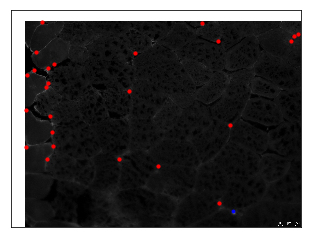

1 correct out of 1
24 false positives 

Index 1
_________________________________________
Processing GREEN image:
Mean: 0.179
Std: 0.0307
Var: 0.0009
Min: 0.1503
Max: 0.3947
351 bright points found
Processing BLUE image:
Mean: 0.0387
Std: 0.0196
Var: 0.0004
Min: 0.0152
Max: 0.0842
726 bright points found
Finding blue/green crossover coordinates
[[192, 596], [567, 161], [590, 896], [795, 1113]]


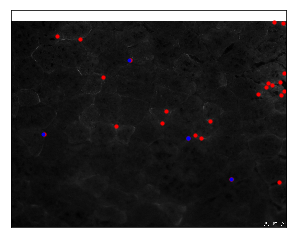

6 correct out of 4
18 false positives 

Index 2
_________________________________________
Processing GREEN image:
Mean: 0.1908
Std: 0.0629
Var: 0.004
Min: 0.15
Max: 0.7159
64 bright points found
Processing BLUE image:
Mean: 0.0435
Std: 0.0215
Var: 0.0005
Min: 0.0152
Max: 0.0848
683 bright points found
Finding blue/green crossover coordinates
[[105, 652], [190, 946]]


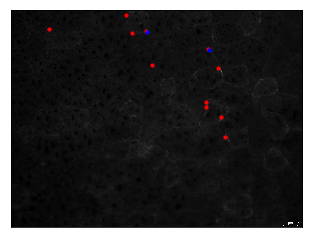

4 correct out of 2
7 false positives 

Index 3
_________________________________________
Processing GREEN image:
Mean: 0.21
Std: 0.0705
Var: 0.005
Min: 0.15
Max: 0.7199
333 bright points found
Processing BLUE image:
Mean: 0.0373
Std: 0.0193
Var: 0.0004
Min: 0.0152
Max: 0.0821
824 bright points found
Finding blue/green crossover coordinates
[[59, 260], [64, 213], [286, 109], [878, 374]]


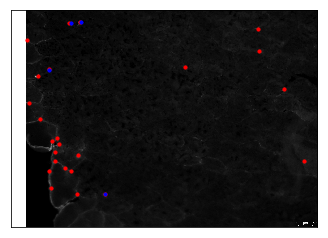

7 correct out of 4
17 false positives 

Index 4
_________________________________________
Processing GREEN image:
Mean: 0.1745
Std: 0.0341
Var: 0.0012
Min: 0.1503
Max: 0.4068
2 bright points found
Processing BLUE image:
Mean: 0.0397
Std: 0.0199
Var: 0.0004
Min: 0.0152
Max: 0.0849
800 bright points found
Finding blue/green crossover coordinates
[[526, 1339], [826, 1251]]


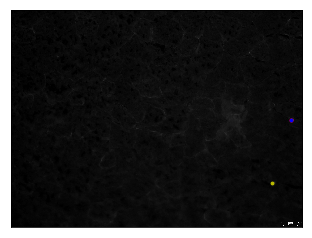

1 correct out of 2
0 false positives 

Index 5
_________________________________________
Processing GREEN image:
Mean: 0.2174
Std: 0.0754
Var: 0.0057
Min: 0.15
Max: 0.6359
97 bright points found
Processing BLUE image:
Mean: 0.0324
Std: 0.016
Var: 0.0003
Min: 0.0152
Max: 0.0818
738 bright points found
Finding blue/green crossover coordinates
[[817, 794], [929, 729]]


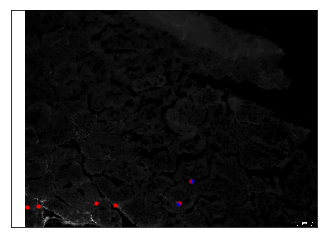

2 correct out of 2
4 false positives 

Index 6
_________________________________________
Processing GREEN image:
Mean: 0.2067
Std: 0.0642
Var: 0.0041
Min: 0.15
Max: 0.7159
446 bright points found
Processing BLUE image:
Mean: 0.0423
Std: 0.0206
Var: 0.0004
Min: 0.0152
Max: 0.0849
567 bright points found
Finding blue/green crossover coordinates
[[255, 937], [834, 854], [971, 764]]


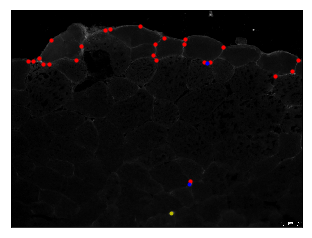

3 correct out of 3
21 false positives 

Index 7
_________________________________________
Processing GREEN image:
Mean: 0.1854
Std: 0.0383
Var: 0.0015
Min: 0.1503
Max: 0.5703
70 bright points found
Processing BLUE image:
Mean: 0.0442
Std: 0.0212
Var: 0.0004
Min: 0.0152
Max: 0.0848
679 bright points found
Finding blue/green crossover coordinates
[]


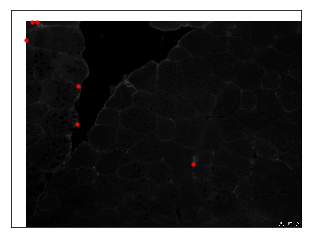

0 correct out of 0
6 false positives 

Index 8
_________________________________________
Processing GREEN image:
Mean: 0.1805
Std: 0.0385
Var: 0.0015
Min: 0.1503
Max: 0.7137
417 bright points found
Processing BLUE image:
Mean: 0.041
Std: 0.0208
Var: 0.0004
Min: 0.0152
Max: 0.0849
811 bright points found
Finding blue/green crossover coordinates
[[53, 961], [263, 120]]


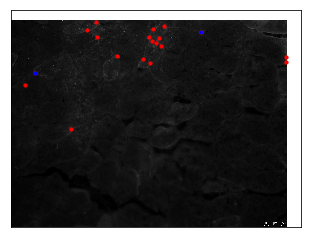

3 correct out of 2
16 false positives 

Index 9
_________________________________________
Processing GREEN image:
Mean: 0.2076
Std: 0.0777
Var: 0.006
Min: 0.1503
Max: 0.7165
123 bright points found
Processing BLUE image:
Mean: 0.0436
Std: 0.0207
Var: 0.0004
Min: 0.0152
Max: 0.0854
749 bright points found
Finding blue/green crossover coordinates
[[746, 274], [1017, 888]]


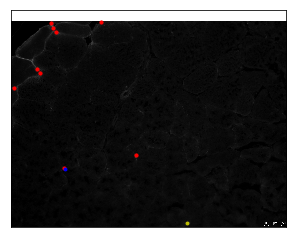

1 correct out of 2
8 false positives 

Index 10
_________________________________________
Processing GREEN image:
Mean: 0.2049
Std: 0.0675
Var: 0.0046
Min: 0.15
Max: 0.7165
TOO MANY POINTS
Processing BLUE image:
Mean: 0.0348
Std: 0.0176
Var: 0.0003
Min: 0.0152
Max: 0.0843
396 bright points found
Finding blue/green crossover coordinates
[[1013, 54]]


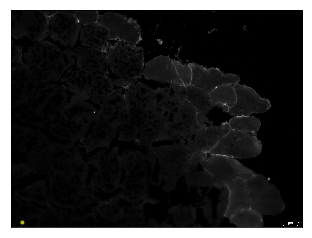

0 correct out of 1
0 false positives 

Index 11
_________________________________________
Processing GREEN image:
Mean: 0.2218
Std: 0.0958
Var: 0.0092
Min: 0.1503
Max: 0.7159
130 bright points found
Processing BLUE image:
Mean: 0.0423
Std: 0.0207
Var: 0.0004
Min: 0.0152
Max: 0.0835
812 bright points found
Finding blue/green crossover coordinates
[[164, 823], [733, 367]]


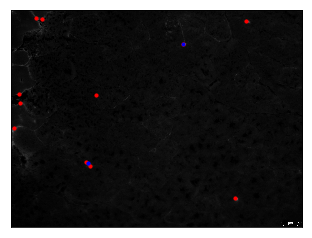

3 correct out of 2
8 false positives 

Index 12
_________________________________________
Processing GREEN image:
Mean: 0.1992
Std: 0.0561
Var: 0.0032
Min: 0.1503
Max: 0.5313
125 bright points found
Processing BLUE image:
Mean: 0.0416
Std: 0.0204
Var: 0.0004
Min: 0.0152
Max: 0.083
650 bright points found
Finding blue/green crossover coordinates
[[685, 1260]]


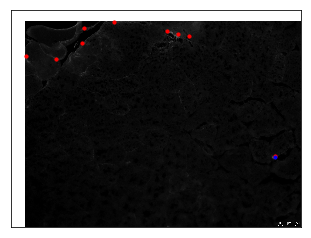

1 correct out of 1
8 false positives 

Index 13
_________________________________________
Processing GREEN image:
Mean: 0.2052
Std: 0.0575
Var: 0.0033
Min: 0.1503
Max: 0.5983
316 bright points found
Processing BLUE image:
Mean: 0.0367
Std: 0.0183
Var: 0.0003
Min: 0.0152
Max: 0.0824
688 bright points found
Finding blue/green crossover coordinates
[[687, 1305], [842, 1355]]


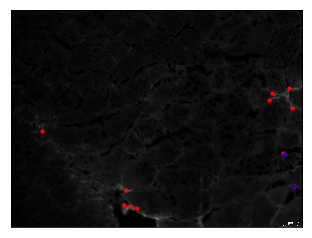

2 correct out of 2
9 false positives 

Index 14
_________________________________________
Processing GREEN image:
Mean: 0.1968
Std: 0.0668
Var: 0.0045
Min: 0.1503
Max: 0.7154
116 bright points found
Processing BLUE image:
Mean: 0.0403
Std: 0.0199
Var: 0.0004
Min: 0.0152
Max: 0.0843
750 bright points found
Finding blue/green crossover coordinates
[[455, 947], [456, 506], [493, 1149]]


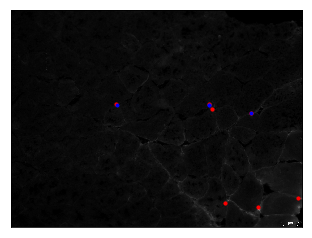

4 correct out of 3
3 false positives 

Index 15
_________________________________________
Processing GREEN image:
Mean: 0.2136
Std: 0.0895
Var: 0.008
Min: 0.15
Max: 0.7168
228 bright points found
Processing BLUE image:
Mean: 0.0419
Std: 0.0208
Var: 0.0004
Min: 0.0152
Max: 0.0835
806 bright points found
Finding blue/green crossover coordinates
[[111, 1044], [316, 873], [341, 1368]]


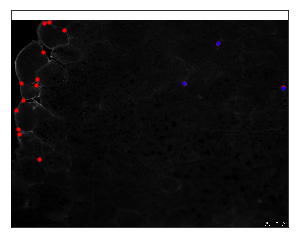

3 correct out of 3
12 false positives 

Index 16
_________________________________________
Processing GREEN image:
Mean: 0.2242
Std: 0.091
Var: 0.0083
Min: 0.15
Max: 0.7188
TOO MANY POINTS
Processing BLUE image:
Mean: 0.0412
Std: 0.0209
Var: 0.0004
Min: 0.0152
Max: 0.0849
887 bright points found
Finding blue/green crossover coordinates
[[297, 1226]]


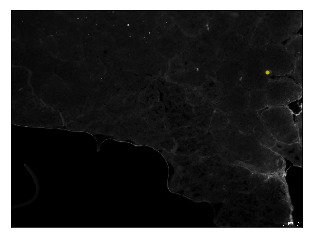

0 correct out of 1
0 false positives 

Index 17
_________________________________________
Processing GREEN image:
Mean: 0.1844
Std: 0.032
Var: 0.001
Min: 0.1503
Max: 0.7199
TOO MANY POINTS
Processing BLUE image:
Mean: 0.0356
Std: 0.0168
Var: 0.0003
Min: 0.0152
Max: 0.0826
784 bright points found
Finding blue/green crossover coordinates
[]


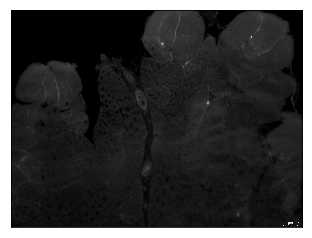

0 correct out of 0
0 false positives 

Index 18
_________________________________________
Processing GREEN image:
Mean: 0.1739
Std: 0.0577
Var: 0.0033
Min: 0.1503
Max: 0.7165
94 bright points found
Processing BLUE image:
Mean: 0.0425
Std: 0.0204
Var: 0.0004
Min: 0.0152
Max: 0.0851
826 bright points found
Finding blue/green crossover coordinates
[[68, 643], [271, 59], [838, 151]]


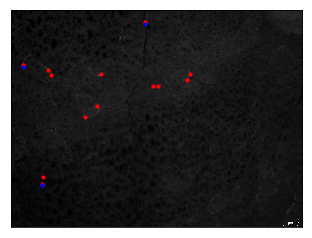

4 correct out of 3
9 false positives 

Index 19
_________________________________________
Processing GREEN image:
Mean: 0.1848
Std: 0.0673
Var: 0.0045
Min: 0.15
Max: 0.7157
87 bright points found
Processing BLUE image:
Mean: 0.0435
Std: 0.0208
Var: 0.0004
Min: 0.0152
Max: 0.0843
TOO MANY POINTS
Finding blue/green crossover coordinates
[[15, 104], [53, 1247], [100, 1225], [316, 1168], [778, 612]]


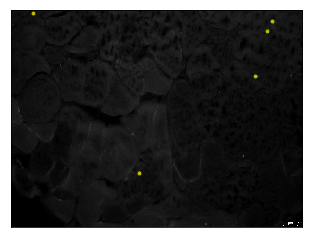

0 correct out of 5
0 false positives 

Index 20
_________________________________________
Processing GREEN image:
Mean: 0.2312
Std: 0.1064
Var: 0.0113
Min: 0.1503
Max: 0.7173
39 bright points found
Processing BLUE image:
Mean: 0.0432
Std: 0.021
Var: 0.0004
Min: 0.0152
Max: 0.0851
915 bright points found
Finding blue/green crossover coordinates
[[100, 342], [626, 265], [916, 1298]]


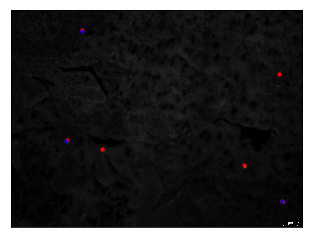

3 correct out of 3
3 false positives 

Index 21
_________________________________________
Processing GREEN image:
Mean: 0.2608
Std: 0.1131
Var: 0.0128
Min: 0.1503
Max: 0.643
23 bright points found
Processing BLUE image:
Mean: 0.0429
Std: 0.0207
Var: 0.0004
Min: 0.0152
Max: 0.086
775 bright points found
Finding blue/green crossover coordinates
[[28, 1219], [31, 364], [92, 1342], [824, 676]]


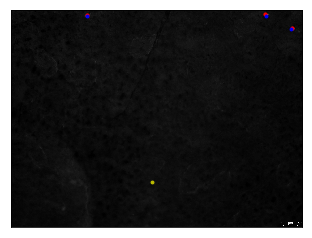

3 correct out of 4
0 false positives 

Index 22
_________________________________________
Processing GREEN image:
Mean: 0.376
Std: 0.1381
Var: 0.0191
Min: 0.15
Max: 0.7165
TOO MANY POINTS
Processing BLUE image:
Mean: 0.0538
Std: 0.0205
Var: 0.0004
Min: 0.0152
Max: 0.0849
TOO MANY POINTS
Finding blue/green crossover coordinates
[[61, 281], [312, 341], [558, 204], [961, 1246]]


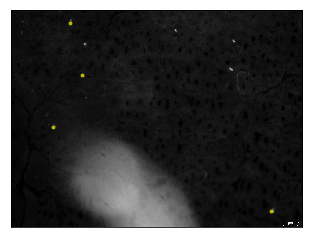

0 correct out of 4
0 false positives 

Index 23
_________________________________________
Processing GREEN image:
Mean: 0.1965
Std: 0.0746
Var: 0.0056
Min: 0.1503
Max: 0.714
97 bright points found
Processing BLUE image:
Mean: 0.046
Std: 0.0214
Var: 0.0005
Min: 0.0152
Max: 0.0843
TOO MANY POINTS
Finding blue/green crossover coordinates
[[267, 975], [379, 1354], [999, 179]]


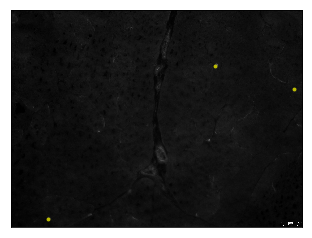

0 correct out of 3
0 false positives 

Index 24
_________________________________________
Processing GREEN image:
Mean: 0.2919
Std: 0.1592
Var: 0.0253
Min: 0.15
Max: 0.7174
61 bright points found
Processing BLUE image:
Mean: 0.0433
Std: 0.0209
Var: 0.0004
Min: 0.0152
Max: 0.0834
884 bright points found
Finding blue/green crossover coordinates
[[277, 896], [283, 279], [785, 849], [889, 945], [959, 713]]


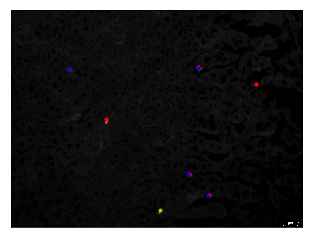

4 correct out of 5
2 false positives 

Index 25
_________________________________________
Processing GREEN image:
Mean: 0.2551
Std: 0.1342
Var: 0.018
Min: 0.15
Max: 0.7165
43 bright points found
Processing BLUE image:
Mean: 0.0448
Std: 0.0212
Var: 0.0005
Min: 0.0152
Max: 0.0843
TOO MANY POINTS
Finding blue/green crossover coordinates
[[53, 298], [145, 1141], [437, 88], [613, 239]]


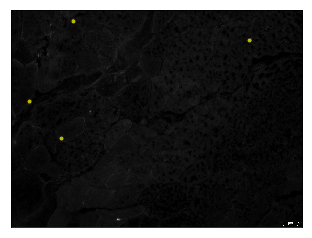

0 correct out of 4
0 false positives 

Index 26
_________________________________________
Processing GREEN image:
Mean: 0.2393
Std: 0.1255
Var: 0.0157
Min: 0.1503
Max: 0.7165
64 bright points found
Processing BLUE image:
Mean: 0.0445
Std: 0.0216
Var: 0.0005
Min: 0.0152
Max: 0.0849
TOO MANY POINTS
Finding blue/green crossover coordinates
[[362, 419], [412, 498], [432, 123], [620, 522], [684, 1063], [703, 602], [770, 1202]]


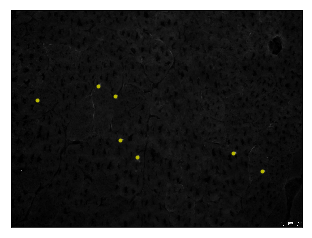

0 correct out of 7
0 false positives 

Index 27
_________________________________________
Processing GREEN image:
Mean: 0.2076
Std: 0.0876
Var: 0.0077
Min: 0.1503
Max: 0.7165
23 bright points found
Processing BLUE image:
Mean: 0.0447
Std: 0.0218
Var: 0.0005
Min: 0.0152
Max: 0.0849
970 bright points found
Finding blue/green crossover coordinates
[[23, 1254], [472, 1111], [853, 1166]]


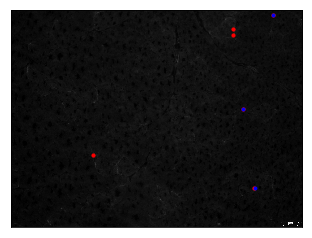

3 correct out of 3
3 false positives 

Index 28
_________________________________________
Processing GREEN image:
Mean: 0.2895
Std: 0.1529
Var: 0.0234
Min: 0.1503
Max: 0.7162
72 bright points found
Processing BLUE image:
Mean: 0.0424
Std: 0.0209
Var: 0.0004
Min: 0.0152
Max: 0.086
TOO MANY POINTS
Finding blue/green crossover coordinates
[[193, 653], [205, 871], [237, 20], [393, 140], [413, 658], [820, 1247], [844, 780], [878, 253], [979, 1051]]


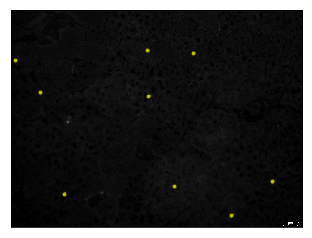

0 correct out of 9
0 false positives 

Index 29
_________________________________________
Processing GREEN image:
Mean: 0.2768
Std: 0.1503
Var: 0.0226
Min: 0.15
Max: 0.7165
89 bright points found
Processing BLUE image:
Mean: 0.042
Std: 0.0212
Var: 0.0004
Min: 0.0152
Max: 0.0849
TOO MANY POINTS
Finding blue/green crossover coordinates
[[9, 290], [139, 1350], [177, 1374], [259, 960], [451, 274], [567, 106], [687, 763], [881, 579], [898, 741]]


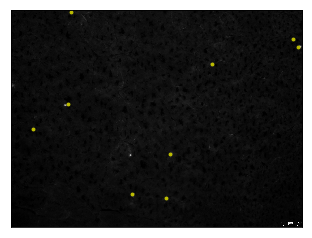

0 correct out of 9
0 false positives 

Index 30
_________________________________________
Processing GREEN image:
Mean: 0.228
Std: 0.0942
Var: 0.0089
Min: 0.1503
Max: 0.5846
30 bright points found
Processing BLUE image:
Mean: 0.0425
Std: 0.0207
Var: 0.0004
Min: 0.0152
Max: 0.084
849 bright points found
Finding blue/green crossover coordinates
[[40, 635], [436, 115], [682, 41], [989, 1276], [1014, 1272]]


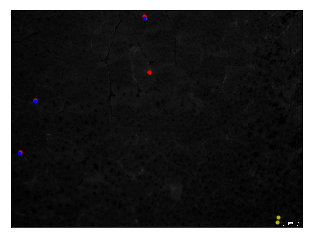

3 correct out of 5
1 false positives 

Index 31
_________________________________________
Processing GREEN image:
Mean: 0.2332
Std: 0.0977
Var: 0.0095
Min: 0.1503
Max: 0.7095
32 bright points found
Processing BLUE image:
Mean: 0.0408
Std: 0.0197
Var: 0.0004
Min: 0.0152
Max: 0.084
803 bright points found
Finding blue/green crossover coordinates
[[115, 71], [225, 624], [361, 1214], [989, 860]]


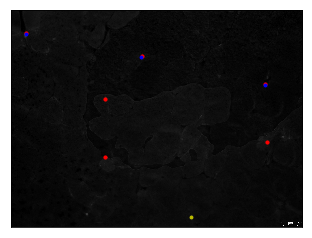

3 correct out of 4
3 false positives 

Index 32
_________________________________________
Processing GREEN image:
Mean: 0.1891
Std: 0.0509
Var: 0.0026
Min: 0.1503
Max: 0.4026
6 bright points found
Processing BLUE image:
Mean: 0.0431
Std: 0.0212
Var: 0.0005
Min: 0.0152
Max: 0.0843
914 bright points found
Finding blue/green crossover coordinates
[[550, 287], [826, 251], [974, 628]]


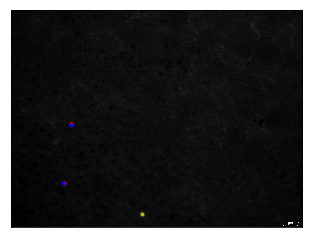

2 correct out of 3
0 false positives 

Index 33
_________________________________________
Processing GREEN image:
Mean: 0.3265
Std: 0.1697
Var: 0.0288
Min: 0.1503
Max: 0.7165
54 bright points found
Processing BLUE image:
Mean: 0.044
Std: 0.0216
Var: 0.0005
Min: 0.0152
Max: 0.0868
TOO MANY POINTS
Finding blue/green crossover coordinates
[[202, 1096], [345, 89], [579, 1367], [893, 1250], [1013, 260]]


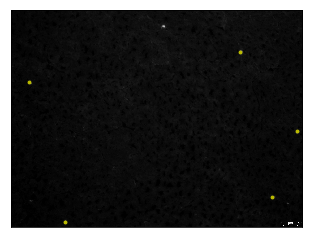

0 correct out of 5
0 false positives 

Index 34
_________________________________________
Processing GREEN image:
Mean: 0.2862
Std: 0.0661
Var: 0.0044
Min: 0.1503
Max: 0.549
TOO MANY POINTS
Processing BLUE image:
Mean: 0.0469
Std: 0.0205
Var: 0.0004
Min: 0.0152
Max: 0.0862
TOO MANY POINTS
Finding blue/green crossover coordinates
[[592, 7], [945, 418]]


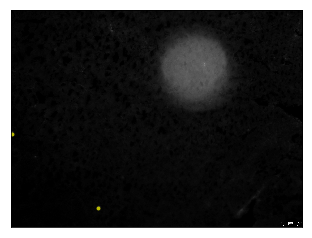

0 correct out of 2
0 false positives 

Index 35
_________________________________________
Processing GREEN image:
Mean: 0.259
Std: 0.136
Var: 0.0185
Min: 0.1503
Max: 0.7168
71 bright points found
Processing BLUE image:
Mean: 0.0422
Std: 0.0206
Var: 0.0004
Min: 0.0151
Max: 0.0835
979 bright points found
Finding blue/green crossover coordinates
[[173, 138], [383, 1238], [562, 644], [640, 964], [792, 267]]


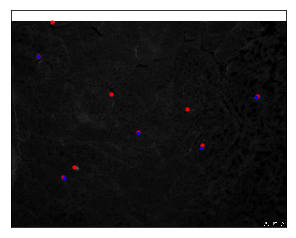

6 correct out of 5
3 false positives 

Index 36
_________________________________________
Processing GREEN image:
Mean: 0.2283
Std: 0.1253
Var: 0.0157
Min: 0.1503
Max: 0.7154
15 bright points found
Processing BLUE image:
Mean: 0.0431
Std: 0.0209
Var: 0.0004
Min: 0.0152
Max: 0.084
869 bright points found
Finding blue/green crossover coordinates
[[548, 248]]


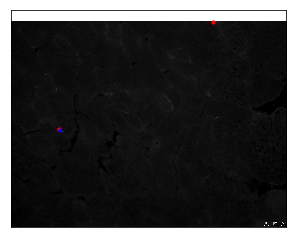

1 correct out of 1
1 false positives 

Index 37
_________________________________________
Processing GREEN image:
Mean: 0.2152
Std: 0.0827
Var: 0.0068
Min: 0.15
Max: 0.637
19 bright points found
Processing BLUE image:
Mean: 0.0369
Std: 0.0192
Var: 0.0004
Min: 0.0152
Max: 0.0859
TOO MANY POINTS
Finding blue/green crossover coordinates
[[340, 224], [944, 1296], [1024, 977]]


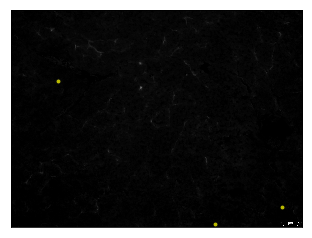

0 correct out of 3
0 false positives 

Index 38
_________________________________________
Processing GREEN image:
Mean: 0.2059
Std: 0.0862
Var: 0.0074
Min: 0.1503
Max: 0.7058
21 bright points found
Processing BLUE image:
Mean: 0.0349
Std: 0.0182
Var: 0.0003
Min: 0.0152
Max: 0.0823
TOO MANY POINTS
Finding blue/green crossover coordinates
[[345, 778], [402, 1232], [567, 245], [610, 765], [753, 884], [803, 117]]


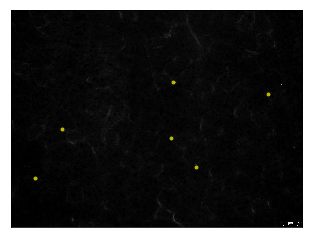

0 correct out of 6
0 false positives 

Index 39
_________________________________________
Processing GREEN image:
Mean: 0.2025
Std: 0.0559
Var: 0.0031
Min: 0.1503
Max: 0.4841
18 bright points found
Processing BLUE image:
Mean: 0.0369
Std: 0.0192
Var: 0.0004
Min: 0.0152
Max: 0.0824
TOO MANY POINTS
Finding blue/green crossover coordinates
[[81, 658]]


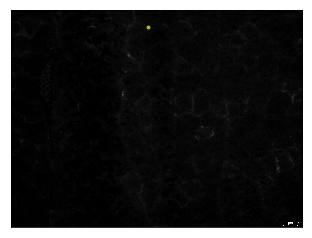

0 correct out of 1
0 false positives 

Index 40
_________________________________________
Processing GREEN image:
Mean: 0.2067
Std: 0.0521
Var: 0.0027
Min: 0.1503
Max: 0.3812
16 bright points found
Processing BLUE image:
Mean: 0.0358
Std: 0.0183
Var: 0.0003
Min: 0.0152
Max: 0.0835
TOO MANY POINTS
Finding blue/green crossover coordinates
[[109, 528], [176, 932], [307, 705], [364, 252]]


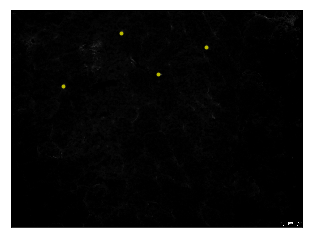

0 correct out of 4
0 false positives 

Index 41
_________________________________________
Processing GREEN image:
Mean: 0.1684
Std: 0.0161
Var: 0.0003
Min: 0.1503
Max: 0.2278
0 bright points found
Processing BLUE image:
Mean: 0.0367
Std: 0.0191
Var: 0.0004
Min: 0.0152
Max: 0.0848
TOO MANY POINTS
Finding blue/green crossover coordinates
[[893, 439]]


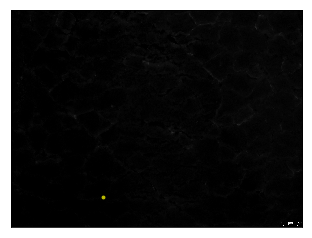

0 correct out of 1
0 false positives 

Index 42
_________________________________________
Processing GREEN image:
Mean: 0.215
Std: 0.063
Var: 0.004
Min: 0.1503
Max: 0.4466
16 bright points found
Processing BLUE image:
Mean: 0.0347
Std: 0.0182
Var: 0.0003
Min: 0.0152
Max: 0.0857
TOO MANY POINTS
Finding blue/green crossover coordinates
[[197, 1009], [501, 466]]


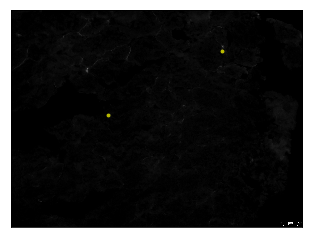

0 correct out of 2
0 false positives 

Index 43
_________________________________________
Processing GREEN image:
Mean: 0.2005
Std: 0.0463
Var: 0.0021
Min: 0.1515
Max: 0.3675
8 bright points found
Processing BLUE image:
Mean: 0.0343
Std: 0.0179
Var: 0.0003
Min: 0.0152
Max: 0.0824
TOO MANY POINTS
Finding blue/green crossover coordinates
[[491, 759], [881, 105]]


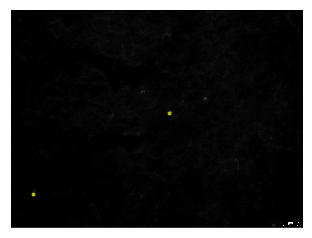

0 correct out of 2
0 false positives 

Index 44
_________________________________________
Processing GREEN image:
Mean: 0.2105
Std: 0.0556
Var: 0.0031
Min: 0.1503
Max: 0.4475
9 bright points found
Processing BLUE image:
Mean: 0.0379
Std: 0.0196
Var: 0.0004
Min: 0.0152
Max: 0.084
TOO MANY POINTS
Finding blue/green crossover coordinates
[[347, 142], [494, 31], [527, 1316], [558, 1282]]


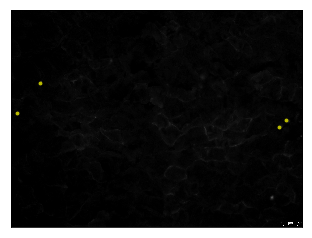

0 correct out of 4
0 false positives 

Index 45
_________________________________________
Processing GREEN image:
Mean: 0.2167
Std: 0.0608
Var: 0.0037
Min: 0.1515
Max: 0.4496
8 bright points found
Processing BLUE image:
Mean: 0.0363
Std: 0.0187
Var: 0.0003
Min: 0.0152
Max: 0.0835
TOO MANY POINTS
Finding blue/green crossover coordinates
[[415, 1097], [1019, 410]]


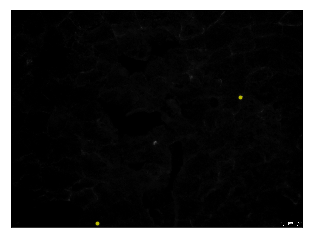

0 correct out of 2
0 false positives 

Index 46
_________________________________________
Processing GREEN image:
Mean: 0.2165
Std: 0.0811
Var: 0.0066
Min: 0.1503
Max: 0.5702
8 bright points found
Processing BLUE image:
Mean: 0.0364
Std: 0.0189
Var: 0.0004
Min: 0.0152
Max: 0.0849
TOO MANY POINTS
Finding blue/green crossover coordinates
[[53, 1118], [126, 575], [665, 1172], [1012, 13]]


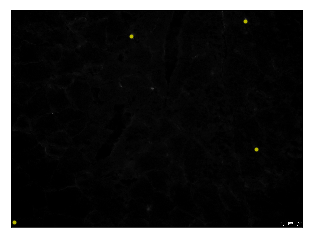

0 correct out of 4
0 false positives 

Index 47
_________________________________________
Processing GREEN image:
Mean: 0.2186
Std: 0.0889
Var: 0.0079
Min: 0.1503
Max: 0.6319
9 bright points found
Processing BLUE image:
Mean: 0.0396
Std: 0.0205
Var: 0.0004
Min: 0.0152
Max: 0.0837
TOO MANY POINTS
Finding blue/green crossover coordinates
[[844, 182]]


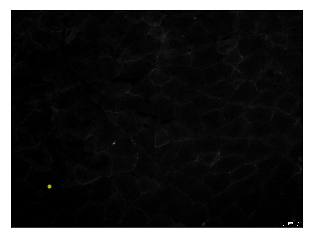

0 correct out of 1
0 false positives 

Index 48
_________________________________________
Processing GREEN image:
Mean: 0.2023
Std: 0.071
Var: 0.005
Min: 0.1503
Max: 0.6816
18 bright points found
Processing BLUE image:
Mean: 0.0382
Std: 0.0199
Var: 0.0004
Min: 0.0152
Max: 0.0849
TOO MANY POINTS
Finding blue/green crossover coordinates
[[373, 1231], [469, 453]]


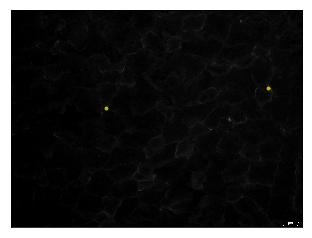

0 correct out of 2
0 false positives 

Index 49
_________________________________________
Processing GREEN image:
Mean: 0.18
Std: 0.0281
Var: 0.0008
Min: 0.15
Max: 0.2845
1 bright points found
Processing BLUE image:
Mean: 0.0403
Std: 0.0205
Var: 0.0004
Min: 0.0152
Max: 0.0868
TOO MANY POINTS
Finding blue/green crossover coordinates
[[148, 733], [179, 834], [593, 110]]


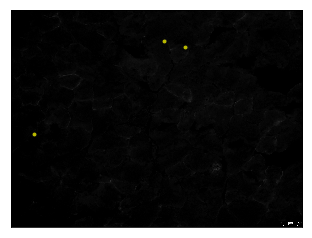

0 correct out of 3
0 false positives 

Index 50
_________________________________________
Processing GREEN image:
Mean: 0.1816
Std: 0.03
Var: 0.0009
Min: 0.1503
Max: 0.3181
1 bright points found
Processing BLUE image:
Mean: 0.0385
Std: 0.0198
Var: 0.0004
Min: 0.0152
Max: 0.0832
TOO MANY POINTS
Finding blue/green crossover coordinates
[]


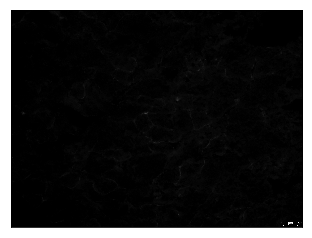

0 correct out of 0
0 false positives 

Index 51
_________________________________________
Processing GREEN image:
Mean: 0.2302
Std: 0.0814
Var: 0.0066
Min: 0.1503
Max: 0.4508
8 bright points found
Processing BLUE image:
Mean: 0.0367
Std: 0.0188
Var: 0.0004
Min: 0.0152
Max: 0.086
TOO MANY POINTS
Finding blue/green crossover coordinates
[[22, 266], [202, 365]]


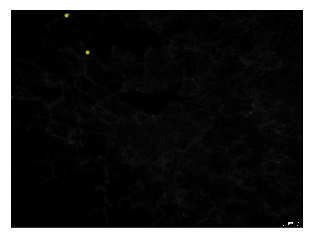

0 correct out of 2
0 false positives 

Index 52
_________________________________________
Processing GREEN image:
Mean: 0.2116
Std: 0.0669
Var: 0.0045
Min: 0.15
Max: 0.5366
10 bright points found
Processing BLUE image:
Mean: 0.0373
Std: 0.0196
Var: 0.0004
Min: 0.0152
Max: 0.0835
TOO MANY POINTS
Finding blue/green crossover coordinates
[[478, 671]]


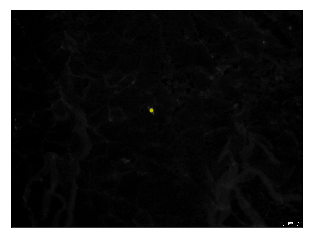

0 correct out of 1
0 false positives 

Index 53
_________________________________________
Processing GREEN image:
Mean: 0.2093
Std: 0.057
Var: 0.0033
Min: 0.1503
Max: 0.6247
175 bright points found
Processing BLUE image:
Mean: 0.0378
Std: 0.0197
Var: 0.0004
Min: 0.0152
Max: 0.0856
TOO MANY POINTS
Finding blue/green crossover coordinates
[[66, 983], [223, 178], [279, 915], [442, 1036], [689, 951], [707, 19]]


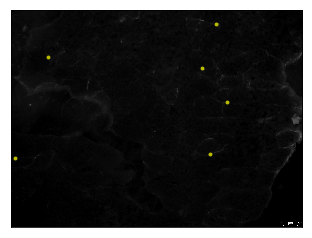

0 correct out of 6
0 false positives 

Index 54
_________________________________________
Processing GREEN image:
Mean: 0.1828
Std: 0.0425
Var: 0.0018
Min: 0.1503
Max: 0.6297
83 bright points found
Processing BLUE image:
Mean: 0.0333
Std: 0.0178
Var: 0.0003
Min: 0.0152
Max: 0.0837
TOO MANY POINTS
Finding blue/green crossover coordinates
[[296, 1072], [300, 1317], [424, 1323], [940, 120]]


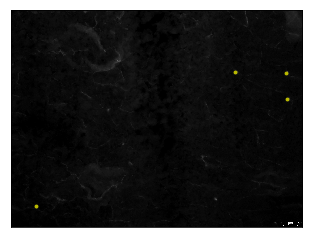

0 correct out of 4
0 false positives 

Index 55
_________________________________________
Processing GREEN image:
Mean: 0.2504
Std: 0.0852
Var: 0.0073
Min: 0.1507
Max: 0.5259
25 bright points found
Processing BLUE image:
Mean: 0.0398
Std: 0.0206
Var: 0.0004
Min: 0.0152
Max: 0.0848
TOO MANY POINTS
Finding blue/green crossover coordinates
[[205, 942], [312, 619], [487, 1348], [699, 1313], [967, 828]]


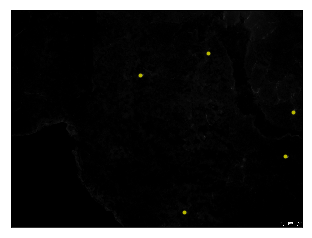

0 correct out of 5
0 false positives 

Index 56
_________________________________________
Processing GREEN image:
Mean: 0.2498
Std: 0.0979
Var: 0.0096
Min: 0.1503
Max: 0.6437
12 bright points found
Processing BLUE image:
Mean: 0.0364
Std: 0.0185
Var: 0.0003
Min: 0.0152
Max: 0.0835
TOO MANY POINTS
Finding blue/green crossover coordinates
[[284, 1005], [409, 341], [824, 531], [944, 610]]


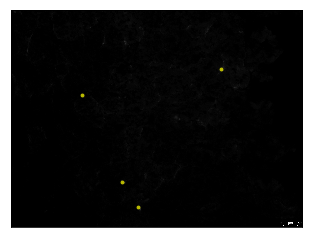

0 correct out of 4
0 false positives 

Index 57
_________________________________________
Processing GREEN image:
Mean: 0.1906
Std: 0.0316
Var: 0.001
Min: 0.1515
Max: 0.2867
11 bright points found
Processing BLUE image:
Mean: 0.0322
Std: 0.0169
Var: 0.0003
Min: 0.0152
Max: 0.081
TOO MANY POINTS
Finding blue/green crossover coordinates
[]


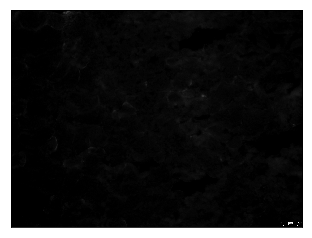

0 correct out of 0
0 false positives 

Index 58
_________________________________________
Processing GREEN image:
Mean: 0.1793
Std: 0.0339
Var: 0.0011
Min: 0.1503
Max: 0.3809
2 bright points found
Processing BLUE image:
Mean: 0.036
Std: 0.0192
Var: 0.0004
Min: 0.0152
Max: 0.0832
TOO MANY POINTS
Finding blue/green crossover coordinates
[]


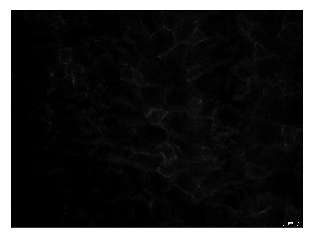

0 correct out of 0
0 false positives 

Index 59
_________________________________________
Processing GREEN image:
Mean: 0.1891
Std: 0.046
Var: 0.0021
Min: 0.1503
Max: 0.3653
5 bright points found
Processing BLUE image:
Mean: 0.0206
Std: 0.0112
Var: 0.0001
Min: 0.0152
Max: 0.0832
TOO MANY POINTS
Finding blue/green crossover coordinates
[]


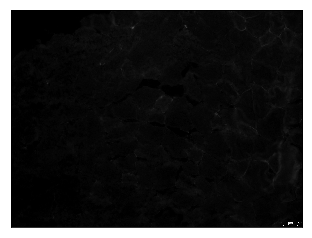

0 correct out of 0
0 false positives 

Index 60
_________________________________________
Processing GREEN image:
Mean: 0.1653
Std: 0.0159
Var: 0.0003
Min: 0.1503
Max: 0.2171
0 bright points found
Processing BLUE image:
Mean: 0.0202
Std: 0.0099
Var: 0.0001
Min: 0.0152
Max: 0.0832
TOO MANY POINTS
Finding blue/green crossover coordinates
[]


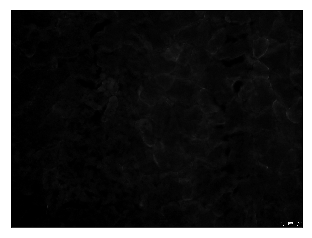

0 correct out of 0
0 false positives 

Index 61
_________________________________________
Processing GREEN image:
Mean: 0.1886
Std: 0.05
Var: 0.0025
Min: 0.15
Max: 0.6222
36 bright points found
Processing BLUE image:
Mean: 0.0396
Std: 0.0204
Var: 0.0004
Min: 0.0152
Max: 0.086
TOO MANY POINTS
Finding blue/green crossover coordinates


FileNotFoundError: [Errno 2] No such file or directory: ''

In [75]:
results = {}

for parameter_id in parameter_settings:
    brightness_threshold_g, brightness_threshold_b = parameter_settings[parameter_id]
    print('Parameter ID: '+str(parameter_id))
    print('**********************************************')
    results[parameter_id] = {}
    for index in range(0,len(all_fps)):
        try:
            correct, false_pos = test_accuracy( index, brightness_threshold_g, brightness_threshold_b )
            results[parameter_id][index] = [correct, false_pos]
        except Exception as e:
            print(e)
            print(':::::::::::::::::::::::::::::::::::::::::::::::::::::')

In [68]:
len(all_fps)

210

In [78]:
def test_accuracy2( index, brightness_threshold_g=0.2, brightness_threshold_b=0.02 ):
    print('\nIndex '+str(index))
    print('_________________________________________')
    
    pax7_fp, dapi_fp, merge_fp = load_fps( index )
    
    print('Processing GREEN image:')
    img_green = load_img( pax7_fp, convert_gray=True)
    #plt.imshow(img_green)
    mean, std, var, minI, maxI = get_stats_gray( img_green, exclude_under=0.15 )
    #plot_hist( img_green, bins=100, exclude_under=.12, exclude_over=1 )

    bright_coordinates_green = get_brightest_coors(img_green, \
                                                   brightness_threshold=brightness_threshold_g, \
                                                   minimum_distance=5, \
                                                   radius=5, \
                                                   convert_gray=True)


    print('Processing BLUE image:')
    img_dapi = load_img( dapi_fp, convert_gray=True)
    #plt.imshow(img_dapi)
    mean, std, var, minI, maxI = get_stats_gray( img_dapi, exclude_under=0.015 )
    #plot_hist( img_green, bins=100, exclude_under=.012, exclude_over=1 )

    bright_coordinates_dapi = get_brightest_coors(img_dapi, \
                                                  brightness_threshold=brightness_threshold_b, \
                                                  minimum_distance=10, \
                                                  convert_gray=True)

    print('Finding blue/green crossover coordinates')
    crossover_coordinates = []
    for green_coor in bright_coordinates_green:
        for dapi_coor in bright_coordinates_dapi:
            dist = get_dist(green_coor,dapi_coor)
            # If two bright points are close enough
            if dist < 10:
                avg_y = (green_coor[0] + dapi_coor[0])/2
                avg_x = (green_coor[1] + dapi_coor[1])/2
                points_too_close_together = False
                # Make sure this point is not very close to other chosen points
                for crossover_coor in crossover_coordinates:
                    cross_dist = get_dist(crossover_coor,[avg_y,avg_x])
                    if cross_dist < 25:
                        points_too_close_together = True
                if not points_too_close_together:
                    crossover_coordinates.append( [avg_y,avg_x] )



    ROI_locations = compute_true_ROIs( merge_fp )
    total_correct_ROIs = 0
    correct_ROIs = []
    for i_true in range( len(ROI_locations) ):
        for i_guess in range( len(crossover_coordinates) ):
            ROI_true = ROI_locations[i_true]
            ROI_guess = crossover_coordinates[i_guess]
            dist = get_dist(ROI_true, ROI_guess)
            if dist<100:
                total_correct_ROIs += 1
                correct_ROIs.append(ROI_true)
                

    plt.imshow(img_green, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    x_coors = []
    y_coors = []
    for coor in crossover_coordinates:
        y, x = coor
        x_coors.append( int(x) )
        y_coors.append( int(y) )
    plt.scatter(x=x_coors, y=y_coors, c='r', s=10)
    
    x_coors = []
    y_coors = []
    x_coors_correct = []
    y_coors_correct = []
    for roi_coor in ROI_locations:
        y, x = roi_coor
        correct = False
        for roi_coor_correct in correct_ROIs:
            if roi_coor==roi_coor_correct:
                x_coors_correct.append( int(x) )
                y_coors_correct.append( int(y) )
                correct = True
        if not correct:
            x_coors.append( int(x) )
            y_coors.append( int(y) )
    plt.scatter(x=x_coors, y=y_coors, c='y', s=8 )
    plt.scatter(x=x_coors_correct, y=y_coors_correct, c='b', s=8 )
    plt.show()
    
    
    print( str(total_correct_ROIs)+' correct out of '+str(len(ROI_locations)) )
    false_positives = len(crossover_coordinates) - total_correct_ROIs
    print( str(false_positives)+' false positives ' )
    try:
        return total_correct_ROIs, false_positives
    except:
        return -1, -1


Index 0
_________________________________________
Processing GREEN image:
Mean: 0.1949
Std: 0.0508
Var: 0.0026
Min: 0.15
Max: 0.5835
380 bright points found
Processing BLUE image:
Mean: 0.0394
Std: 0.0199
Var: 0.0004
Min: 0.0152
Max: 0.0835
517 bright points found
Finding blue/green crossover coordinates
[[959, 1050]]


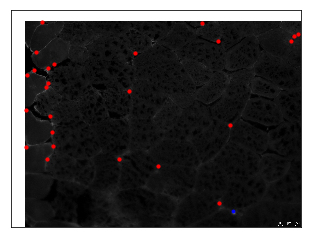

1 correct out of 1
24 false positives 


In [77]:
correct, false_pos = test_accuracy2( 0, brightness_threshold_g, brightness_threshold_b )

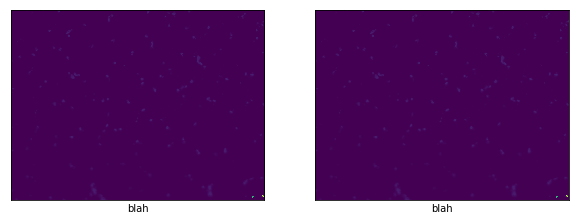

In [26]:
plt.figure(figsize=(10,20))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img_dapi)
    plt.xlabel('blah')

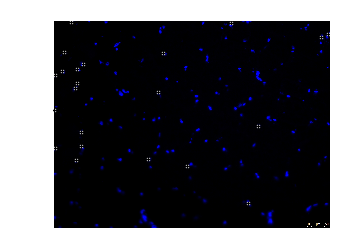

In [12]:
img_merge = load_img( dapi_fp, convert_gray=False)

plt.imshow(img_merge, cmap='gray')
x_coors = []
y_coors = []
for coor in crossover_coordinates:
    y, x = coor
    x_coors.append( int(x) )
    y_coors.append( int(y) )
    
my_dpi = 350
# plt.scatter(x=x_coors, y=y_coors, c='w', s=10, alpha=0.3)
plt.scatter(x=x_coors, y=y_coors, c='w', marker ='x', s=7, alpha=1)
plt.scatter(x=x_coors, y=y_coors, c='k', marker ='x', s=3, alpha=1)
plt.axis('off')
pylab.savefig(root_fp+'output.png', bbox_inches='tight', figsize=(1392/my_dpi, 1040/my_dpi), dpi=my_dpi)
plt.show()